# Import libraries

In [4]:

# to access my files
import PIL.Image as Image # to open images on my computer
import os
import random

#Plotiing
import matplotlib.pylab as plt

#tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from keras.applications.mobilenet_v2 import MobileNetV2 # to use the mobilenet model
from tensorflow.keras.models import Model # to create a model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Conv2D # to add layers to the model
from tensorflow.keras.optimizers import Adam,RMSprop,SGD # Diffrent optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory # to load the dataset
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
                                        # Early stopping  to ensure prevention of  overfitting  during train
                                        # Model checkpoint to save the best model during training


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Define the data's directory path, batches, split for training, validation and testing

In [5]:
# Dataset parameters
trainingDatasetDir = "asl_alphabet_train/asl_alphabet_train" # Path to the training dataset
batchSize = 32
IMAGE_SHAPE = (224, 224)



# Load the dataset without splitting
full_dataset = image_dataset_from_directory(
    trainingDatasetDir,
    image_size=IMAGE_SHAPE,
    batch_size=batchSize,
    shuffle=True,
    label_mode='categorical',
    seed=123  # Ensure reproducibility
)

# Get the total number of samples
dataset_size = len(full_dataset) * batchSize

# Calculate sizes for each split
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset = full_dataset.take(train_size // batchSize)
remaining = full_dataset.skip(train_size // batchSize)

val_dataset = remaining.take(val_size // batchSize)
test_dataset = remaining.skip(val_size // batchSize)

# Optional: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Testing dataset size: {test_size}")


Found 84000 files belonging to 28 classes.
Training dataset size: 58799
Validation dataset size: 12600
Testing dataset size: 12601


### checking the dataset

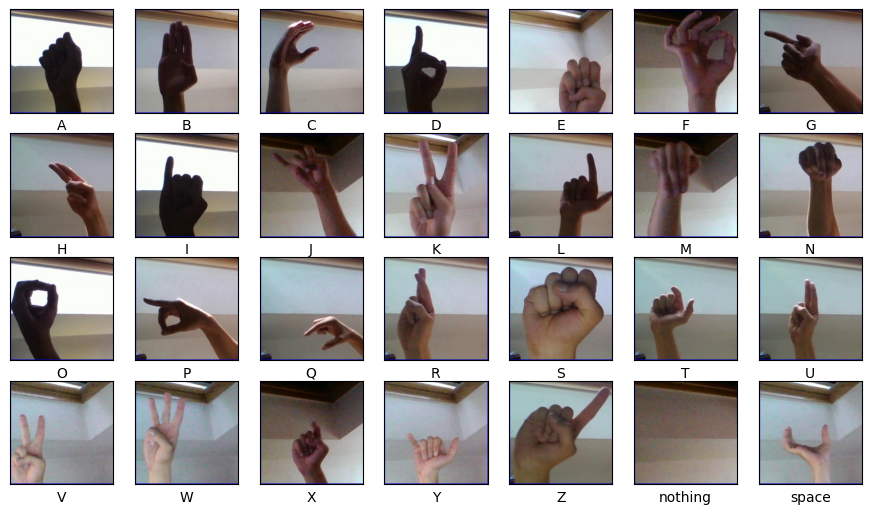

In [6]:

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
            'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
            'W', 'X', 'Y', 'Z', 'nothing', 'space'] 
            # optionally you can add del if you have del class in you dataset directory
            
plt.figure(figsize=(11, 11))
for i in range (0,28):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path =  f"{trainingDatasetDir}/{classes[i]}/{classes[i]}{random.randint(1, 3000)}.jpg"
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

## Defining number of classes and applying one hot encoding

In [7]:
numberOfClasses = 28


train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y)).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
for x, y in test_dataset.take(2):
    print(x.shape, y.shape)

(32, 224, 224, 3) (32, 28)
(32, 224, 224, 3) (32, 28)


2025-01-02 20:12:25.238698: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Importing the original model brought by tensorflow without it's top layer
### (MobileNet V2)


In [9]:
# model = MobileNetV2(weights='imagenet') # Load the mobilenet model with pre-trained weights
# above is the original way of mobilenet model with pre-trained weights
# but we get an error saying that the weights are nnot downloadable
# so we will use the following way to load the weithts to the model
# here is a link where you can find diffrent initial weights for the model
# https://github.com/JonathanCMitchell/mobilenet_v2_keras/releases/ 



mobileNetV2BaseModel = MobileNetV2(input_shape=IMAGE_SHAPE+(3,), include_top=False, weights=None)
mobileNetV2BaseModel.load_weights('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')


## Freezing the base input layer of the ariginal model

In [8]:
mobileNetV2BaseModel.trainable = False

## Adding my own top layers

#### 5 layers

In [9]:
x = mobileNetV2BaseModel.output
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(1024, activation='relu')(x)
predictions = Dense(numberOfClasses, activation='softmax')(x)


## Initializing my own model

In [10]:

mobiletNetV2ASLModel = Model(inputs=mobileNetV2BaseModel.input, outputs=predictions)


## Compiling my model

In [11]:
############# 1st optimizer is Adam ###################

#optimizer=Adam(learning_rate=0.001)

############# 2nd optimizer is RMSprop ###################


# optimizer = RMSprop(
#     learning_rate=0.001,  # Set the learning rate (you might need to tune this)
#     rho=0.9,  # Decay rate for the moving average of squared gradients
#     epsilon=1e-07,  # Small value to avoid division by zero
#     # ... other parameters if needed ...
# )

############# 3rd optimizer is RMSprop ###################

# optimizer = SGD(
#     learning_rate=0.01,  # Set the learning rate
#     momentum=0.9,  # Momentum value (typically between 0.5 and 0.9)
#     # ... other parameters if needed ...
# )

##############################################################

# sparse_categorical_crossent not used because we are using one hot encoding

##############################################################

mobiletNetV2ASLModel.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )

## checkpoints

In [12]:
# Add callbacks
checkpoint_path = "mobiletNetV2ASLModel/cp-{epoch:02d}-{val_loss:.2f}.keras"
modelCheckpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

## Implementing Early stopping to prevent overfitting

In [13]:
earlyStopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss in this case)
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

## Training and tracing activity through tensor boad

In [14]:
# history = ASLModel.fit(
#     trainingDataset,
#     validation_data= validationDataset,
#     epochs=15,
#     verbose=1,
#     callbacks=[earlyStopping]  # Add the early_stopping callback here

# )

# Train the model
history = mobiletNetV2ASLModel.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    verbose=1,
    callbacks=[earlyStopping, modelCheckpoint]
)

Epoch 1/15
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2926 - loss: 2.2887
Epoch 1: val_loss improved from inf to 0.56230, saving model to mobiletNetV2ASLModel/cp-01-0.56.keras
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 471s 256ms/step - accuracy: 0.2927 - loss: 2.2884 - val_accuracy: 0.8519 - val_loss: 0.5623
Epoch 2/15
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5926 - loss: 1.2652
Epoch 2: val_loss improved from 0.56230 to 0.40596, saving model to mobiletNetV2ASLModel/cp-02-0.41.keras
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 493s 268ms/step - accuracy: 0.5927 - loss: 1.2652 - val_accuracy: 0.8949 - val_loss: 0.4060
Epoch 3/15
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6652 - loss: 1.0421
Epoch 3: val_loss did not improve from 0.40596
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 502s 273ms/step - accuracy: 0.6652 - loss: 1.0421 - val_accuracy: 0.8590 - val_loss: 0.4897
Epoch 4/15
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7014 - loss: 0.9363
Epoch 4: val_los

## Saving the model

In [22]:
mobiletNetV2ASLModel.save("mobiletNetV2ASLModel.keras")


from tensorflow.keras.models import load_model
loaded_model = load_model("mobiletNetV2ASLModel.keras")


#Plot preparation
#### collecting data from history object returned by ASLModel.fit()

In [17]:
trainingAccuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']
trainingLoss = history.history['loss']
validationLoss = history.history['val_loss']

## Plotting the results

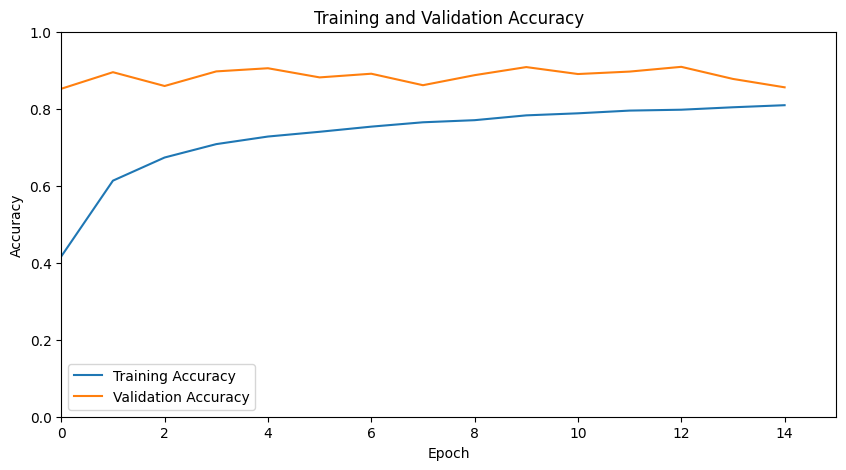

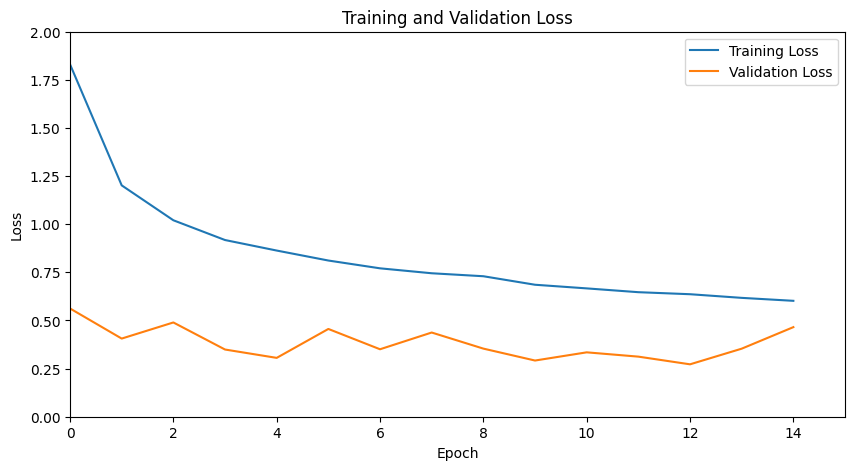

In [21]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(trainingAccuracy, label='Training Accuracy')
plt.plot(validationAccuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([0, 15])
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(trainingLoss, label='Training Loss')
plt.plot(validationLoss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.xlim([0, 15])
plt.legend()
plt.show()

# Confusion Matrix

In [23]:
import numpy as np


# Evaluate the model using a confusion matrix
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = loaded_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-12-31 08:40:25.744377: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


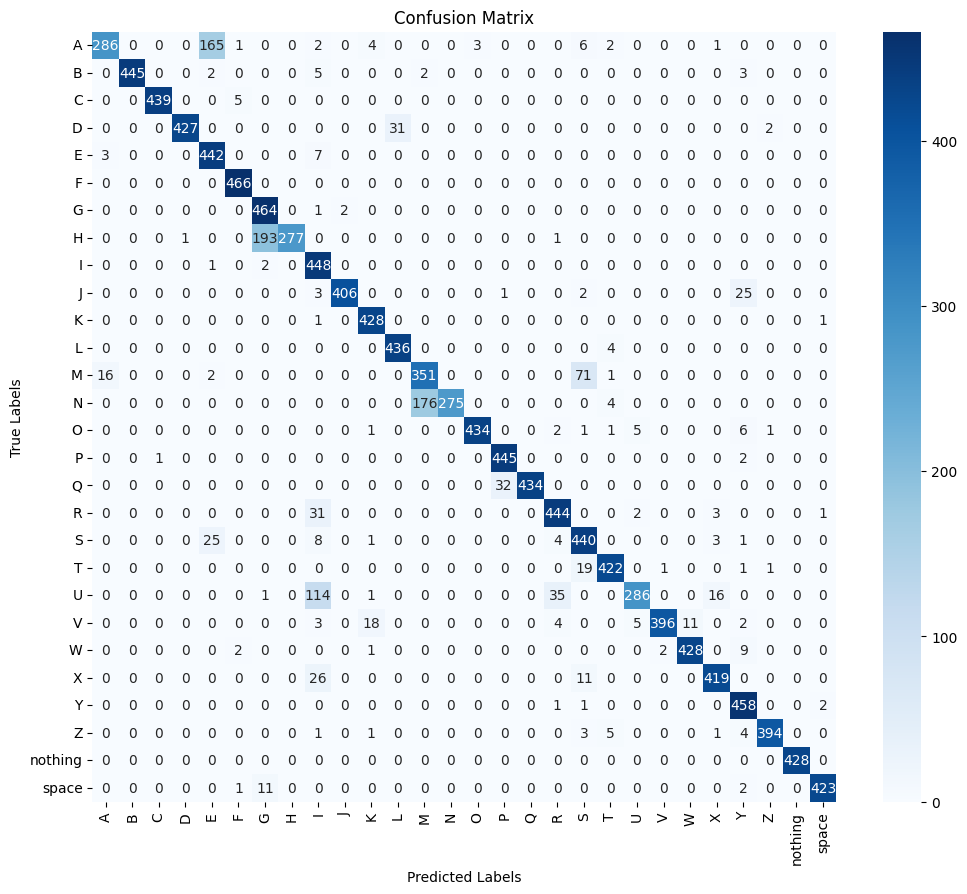

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(full_dataset.class_names)  # Get class names from dataset

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



## Metrics

In [27]:
import pandas as pd

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_csv_path = "TransferLearningClassificationRepors.csv"
report_df.to_csv(report_csv_path, index=True)
print(f"Classification report saved successfully to {report_csv_path}.")


Classification Report:

              precision    recall  f1-score   support

           A       0.94      0.61      0.74       470
           B       1.00      0.97      0.99       457
           C       1.00      0.99      0.99       444
           D       1.00      0.93      0.96       460
           E       0.69      0.98      0.81       452
           F       0.98      1.00      0.99       466
           G       0.69      0.99      0.82       467
           H       1.00      0.59      0.74       472
           I       0.69      0.99      0.81       451
           J       1.00      0.93      0.96       437
           K       0.94      1.00      0.97       430
           L       0.93      0.99      0.96       440
           M       0.66      0.80      0.72       441
           N       1.00      0.60      0.75       455
           O       0.99      0.96      0.98       451
           P       0.93      0.99      0.96       448
           Q       1.00      0.93      0.96       466
   